In [9]:
# Set up working directory & Import necessary
import os
os.chdir('/Users/zepedalab/Desktop/MATHia_NLP_YB')

import pandas as pd # for manipulating dataframe
import re # for regular expression
import spacy #for NLP analysis
#!python3 -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")

In [10]:
# Import Data File
text_df = pd.read_excel('/Users/zepedalab/Desktop/MATHia_NLP_YB/NLP Dataset.xlsx')

In [11]:
# Pre-process the text data (text_df)
# Convert the text input to the lower case string
# Remove all non-alphabetic characters
text_df['input'] = text_df['input'].astype(str)
text_df['input'] = text_df['input'].str.lower()
text_df['input'] = text_df['input'].str.replace(r'[^a-zA-Z\s]', '', regex=True)
# Filter out any input that comprise less than 3 characters
text_df = text_df[text_df['input'].str.len() >= 3]
short_input_df = text_df[text_df['input'].str.len() < 3] #short_input_df allows us to manually check

In [12]:
# Detecting the nonsense string
from nostril import nonsense
short_indices = []
nonsense_indices = []

# Iterate through rows and separate nonsense rows
for index, row in text_df.iterrows():
    try:
        text = row['input']
        if len(text) < 6: # Check if the text is too short to test
            # Add the short text to short_text_df
            if len(text) < 6:
                short_indices.append(index)
            continue

        # Use nostril to detect nonsense in the current row's text
        if nonsense(text):
            nonsense_indices.append(index)

    except Exception as e:
        msg = str(e)
        if "Text is too short to test" in msg:
             short_indices.append(index)
        else:
            print(f"Error processing row {index}: {e}")

short_text_df = text_df.loc[short_indices]
nonsense_df = text_df.loc[nonsense_indices]
text_df = text_df.drop(nonsense_indices)

In [13]:
# Quicklook on the first 10 nonsense string
nonsense_df.input[:10]

4                                  jjjnnknjmimkkikiilkin
99                                           ummmmmm idk
103    jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj...
159                                              yayyyyy
162    dddddddddddddddddddddddddddddddddddddddddddddd...
263                            iiiiiiiiiiiiiiiiiiiiii kj
359                                           v guvghibj
463                                             ndcfksdj
480                                   ibhuiygutgcytuyvjh
505                                               jkkkkk
Name: input, dtype: object

In [14]:
# Pre-process those shor input by using the gibberish detector
from gibberish_detector import detector
Detector = detector.create_from_model('/Users/zepedalab/PycharmProjects/MATHia-NLP-YB/gibberish-detector.model')

In [16]:
gibberish_indices = []

# Iterate through rows and separate gibberish rows
for index, row in text_df.iterrows():
    try:
        # Check if the row is gibberish
        is_gibberish = Detector.is_gibberish(row['input'])

        # If it is gibberish, add to the gibberish_df and remove from text_df_3
        if is_gibberish:
            gibberish_indices.append(index)

    except Exception as e:
        print(f"Error processing row {index}: {e}")

gibberish_df = text_df.loc[gibberish_indices]
text_df = text_df.drop(gibberish_indices)

In [17]:
# Quicklook on the first 10 gibberish string
gibberish_df.input[:10]

93      bruhhhh
111    r gtktnq
113         idk
190         idk
191         idk
193         kjh
213        kklj
246         idk
254        jhgj
258         idk
Name: input, dtype: object

In [18]:
# Load spacy model
nlp = spacy.load("en_core_web_lg")

# Define a helper function to process text using spaCy
def spacy_preprocessor(texts):
    processed_docs = []
    # disable parser and ner for speed since we only need tokenization/lemmatization
    for doc in nlp.pipe(texts, disable=["parser", "ner"]):
        # Lemmatize, lowercase, remove stopwords and non-alphabetic chars
        tokens = [
            token.lemma_.lower()
            for token in doc
            if not token.is_stop and token.is_alpha
        ]
        processed_docs.append(tokens)
    return processed_docs

# Call the helper function for Tokenize and lemmatize
tokenized_docs = spacy_preprocessor(text_df['input'].astype(str))

# Add tokens to dataframe temporarily to keep alignment safe
text_df['tokens'] = tokenized_docs

# Filter rows where the token list is not empty
text_df_filtered = text_df[text_df['tokens'].map(len) > 0].copy()

# Create the filtered docs list for Gensim
filtered_docs = text_df_filtered['tokens'].tolist()

# Create the cleaned string representation
text_df_filtered["cleaned_input"] = text_df_filtered['tokens'].apply(lambda x: ' '.join(x))


In [19]:
gibberish_indices = []

# Iterate through rows and separate gibberish rows
for index, row in text_df.iterrows():
    try:
        # Check if the row is gibberish
        is_gibberish = Detector.is_gibberish(row['input'])

        # If it is gibberish, add to the gibberish_df and remove from text_df_3
        if is_gibberish:
            gibberish_indices.append(index)

    except Exception as e:
        print(f"Error processing row {index}: {e}")

gibberish_df = text_df.loc[gibberish_indices]
text_df = text_df.drop(gibberish_indices)

In [20]:
# Detecting the nonsense string
from nostril import nonsense
short_indices = []
nonsense_indices = []

# Iterate through rows and separate nonsense rows
for index, row in text_df.iterrows():
    try:
        text = row['input']
        if len(text) < 6: # Check if the text is too short to test
            # Add the short text to short_text_df
            if len(text) < 6:
                short_indices.append(index)
            continue

        # Use nostril to detect nonsense in the current row's text
        if nonsense(text):
            nonsense_indices.append(index)

    except Exception as e:
        msg = str(e)
        if "Text is too short to test" in msg:
             short_indices.append(index)
        else:
            print(f"Error processing row {index}: {e}")

short_text_df = text_df.loc[short_indices]
nonsense_df = text_df.loc[nonsense_indices]
text_df = text_df.drop(nonsense_indices)

In [21]:
import gensim
from gensim import corpora
# create empty dictionary from gensim library (for the vocabulary)
dictionary = gensim.corpora.Dictionary()
# iteratively add each doc to the bag-of-words corpus
bow_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in text_df_filtered["tokens"]]

In [22]:
import numpy as np

# Get vocab from dictionary
vocab = pd.Series(dictionary.token2id).index

# Sequence of numbers as long as the documents
index = range(len(bow_corpus))

# Create a pandas dataframe full of zeros.
bow_df = pd.DataFrame(data=np.zeros((len(bow_corpus), len(dictionary)), dtype=np.float32),
                  index=index, # row labels
                  columns=vocab) #column labels

# Add each word from the bag-of-words corpus to the matrix.
for idx in index:
  for id, freq in bow_corpus[idx]:
    bow_df.loc[idx,dictionary[id]] = freq

# Transpose the matrix for easy reading
bow_df

,awaly,time,well,nan,ask,classmate,classs,fellow,focus,help,...,motavite,unit,continue,fun,create,different,anymore,suffer,motivational,disiplince
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
563,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [23]:
# Calculating Inverse Document Frequency
num_documents = len(bow_df) #get the length of the documents

# function of idf
def idf(term):
  documents_containing_term = (bow_df[term] > 0).sum()    # sum of documents containing the term
  return np.log(num_documents+1/documents_containing_term+1)  # divide the number of documents by the num documents with the term and get the log.

# dictionary comprehension to apply the idf function to every word (column) in the bow_df DataFrame
idf = pd.Series({term:idf(term) for term in bow_df.columns}) # create dictionary with key value pair of term:idf(term)

#Calculate Term Frequency
# divide each token count by the total token count for the row.
tf_df = bow_df.div(bow_df.sum(axis='columns'), axis='rows')

#Calculate the TF-IDF score
tfidf_df = tf_df.copy().multiply(idf, axis='columns')
# make copy of tf_df that is tf/idf

# Quick view on tf-idf metrix
tfidf_df

,awaly,time,well,nan,ask,classmate,classs,fellow,focus,help,...,motavite,unit,continue,fun,create,different,anymore,suffer,motivational,disiplince
0,2.114627,2.114094,2.114114,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.000000,0.000000,0.000000,6.34214,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.000000,0.000000,0.000000,6.34214,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.000000,0.000000,0.000000,6.34214,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.00000,1.40939,0.704778,0.704876,0.704876,0.704692,0.704687,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,0.000000,0.000000,0.000000,6.34214,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
563,0.000000,0.000000,0.000000,6.34214,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
564,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.268776,0.000000
565,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.057313


In [24]:
# Force both objects to use the same simple index 0..N-1
text_df_filtered = text_df_filtered.reset_index(drop=True)
tfidf_df = tfidf_df.reset_index(drop=True)

# now they share the same index
assert all(text_df_filtered.index == tfidf_df.index)


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def run_logreg_cv_for_code(code_col, text_df_filtered, tfidf_df,
                           n_splits=10,
                           balance_seed=12434,
                           shuffle_seed=14312):
    """
    10-fold cross-validation for a single human code (e.g., 'Willpower').

    - Uses the FULL original (imbalanced) dataset for CV
    - For EACH fold:
        * Keep test fold imbalanced (realistic)
        * Balance ONLY the training fold via random downsampling
        * Train logistic regression on balanced training data
        * Evaluate on imbalanced test data
    - Prints mean accuracy/precision/recall/F1 across folds
    - Shows aggregated confusion matrix across folds
    """

    print(f"\n======================== 10-fold CV: {code_col} ========================")

    # 1. Prepare target y just like in your original function
    col = text_df_filtered[code_col]
    y_raw = pd.to_numeric(col, errors='coerce').fillna(0).astype(int)

    print("Unique values after cleaning:", sorted(y_raw.unique()))

    # 2. Align X and y by shared indices
    valid_idx = tfidf_df.index.intersection(y_raw.index)
    X = tfidf_df.loc[valid_idx]
    y = y_raw.loc[valid_idx]

    print("\nRaw class counts:")
    print(y.value_counts())

    if y.nunique() < 2:
        print(f"Not enough variation in {code_col} (only one class).")
        return None

    # 3. Set up Stratified K-Fold (to preserve class ratio in each fold)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=shuffle_seed)

    # To store metrics from each fold
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []

    # For aggregated confusion matrix
    labels = sorted(y.unique())
    agg_confusion = np.zeros((len(labels), len(labels)), dtype=int)

    fold_id = 1
    for train_idx, test_idx in skf.split(X, y):
       # print(f"\n--- Fold {fold_id} ---")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        print("Train class counts BEFORE balancing:")
        print(y_train.value_counts())
        print("Test class counts (imbalanced, as in real data):")
        print(y_test.value_counts())

        # 4. Balance ONLY the training set via downsampling
        class_counts = y_train.value_counts()
        minority_class = class_counts.idxmin()
        majority_class = class_counts.idxmax()
        n_minority = class_counts.min()

        minority_idx = y_train[y_train == minority_class].index
        majority_idx_sampled = y_train[y_train == majority_class].sample(
            n=n_minority,
            random_state=balance_seed + fold_id  # change seed slightly per fold
        ).index

        balanced_idx = minority_idx.union(majority_idx_sampled)

        X_train_bal = X_train.loc[balanced_idx]
        y_train_bal = y_train.loc[balanced_idx]

        # Shuffle the balanced training set
        X_train_bal, y_train_bal = shuffle(
            X_train_bal, y_train_bal, random_state=shuffle_seed + fold_id
        )

        print("Train class counts AFTER balancing:")
        print(y_train_bal.value_counts())

        # 5. Train logistic regression on balanced training data
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train_bal, y_train_bal)

        # 6. Predict on the IMBALANCED test fold
        y_pred = clf.predict(X_test)

        # 7. Compute metrics for this fold
        acc = metrics.accuracy_score(y_test, y_pred)
        prec = metrics.precision_score(y_test, y_pred, zero_division=0)
        rec = metrics.recall_score(y_test, y_pred, zero_division=0)
        f1 = metrics.f1_score(y_test, y_pred, zero_division=0)

        fold_accuracies.append(acc)
        fold_precisions.append(prec)
        fold_recalls.append(rec)
        fold_f1s.append(f1)

        print(f"Fold {fold_id} Accuracy:  {acc:.3f}")
        print(f"Fold {fold_id} Precision: {prec:.3f}")
        print(f"Fold {fold_id} Recall:    {rec:.3f}")
        print(f"Fold {fold_id} F1-score:  {f1:.3f}")

        # Update aggregated confusion matrix
        cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
        agg_confusion += cm

        fold_id += 1

    # 8. Print average performance across folds
    print("\n========== 10-fold CV Summary ==========")
    print(f"Mean Accuracy:  {np.mean(fold_accuracies):.3f} (+/- {np.std(fold_accuracies):.3f})")
    print(f"Mean Precision: {np.mean(fold_precisions):.3f} (+/- {np.std(fold_precisions):.3f})")
    print(f"Mean Recall:    {np.mean(fold_recalls):.3f} (+/- {np.std(fold_recalls):.3f})")
    print(f"Mean F1-score:  {np.mean(fold_f1s):.3f} (+/- {np.std(fold_f1s):.3f})")

    # 9. Show aggregated confusion matrix across all folds
    plt.figure(figsize=(4, 3))
    sns.heatmap(agg_confusion,
                annot=True,
                fmt='d',
                xticklabels=labels,
                yticklabels=labels)
    plt.title(f'Aggregated Confusion Matrix – {code_col} (10-fold CV)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # Optionally return the per-fold metrics for later use
    results = {
        "accuracy": fold_accuracies,
        "precision": fold_precisions,
        "recall": fold_recalls,
        "f1": fold_f1s,
        "labels": labels,
        "confusion_matrix": agg_confusion
    }
    return results



Running REDUCED MODEL for Willpower

========== 10-fold CV Summary (class_weight=balanced) ==========
Mean Accuracy:  0.859 (+/- 0.031)
Mean Precision: 0.606 (+/- 0.107)
Mean Recall:    0.692 (+/- 0.124)
Mean F1-score:  0.635 (+/- 0.070)


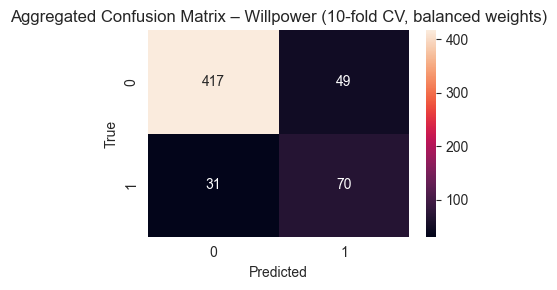


Top 20 positive predictor words (for class = 1):
push                            1.7830
try                             1.1711
belve                           1.1586
go                              1.1304
ill                             1.0019
matter                          0.9788
focused                         0.9556
keep                            0.9344
foucse                          0.9270
tre                             0.9125
want                            0.8972
mathia                          0.8532
continue                        0.8417
person                          0.8282
belive                          0.8158
work                            0.8067
keept                           0.7909
will                            0.7778
stuck                           0.7443
persevere                       0.7423

Top 20 negative predictor words (for class = 1):
grade                          -1.3557
math                           -1.2717
think                          -1.1364
fai

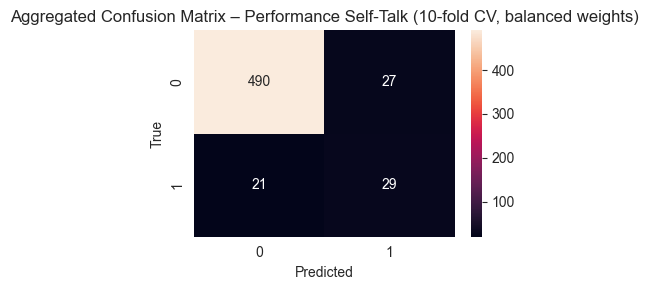


Top 20 positive predictor words (for class = 1):
grade                           3.7463
people                          1.1415
tellig                          1.1272
don                             1.0916
well                            1.0859
homework                        1.0789
improve                         1.0692
test                            1.0433
workspace                       1.0409
zero                            0.9773
progress                        0.9487
away                            0.9487
ill                             0.9289
feel                            0.9195
possible                        0.9131
acadamy                         0.9084
pass                            0.9071
to                              0.8406
hall                            0.8406
recess                          0.8406

Top 20 negative predictor words (for class = 1):
tell                           -1.0621
fail                           -0.8423
not                            -0.8078
nan

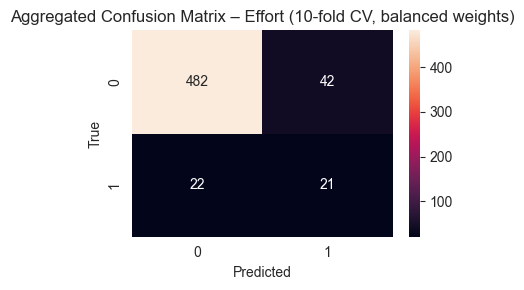


Top 20 positive predictor words (for class = 1):
everyday                        2.2647
reward                          1.7371
wrong                           1.7326
solution                        1.6551
motivated                       1.2988
use                             1.2879
look                            1.2103
figure                          1.1775
orkpsace                        1.0925
couple                          1.0925
equation                        1.0881
problem                         1.0558
caculate                        1.0556
hope                            1.0141
question                        1.0140
hint                            1.0107
class                           0.9646
content                         0.9420
hit                             0.8489
hecke                           0.8489

Top 20 negative predictor words (for class = 1):
grade                          -1.0822
agree                          -0.8498
nan                            -0.8259
wan

In [39]:
codes = ['Willpower', 'Performance Self-Talk', 'Effort']

reduced_results = {}

for code in codes:
    print("\n==============================")
    print(f"Running REDUCED MODEL for {code}")
    print("==============================")

    results = run_logreg_cv_for_code_balanced(
        code_col=code,
        text_df_filtered=text_df_filtered,
        tfidf_df=tfidf_df
    )

    # store results by code name
    reduced_results[code] = results


In [36]:
#Train by the imbalance data set
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def run_logreg_cv_for_code_balanced(code_col, text_df_filtered, tfidf_df,
                                    n_splits=10,
                                    shuffle_seed=14312):
    """
    10-fold cross-validation for a single human code (e.g., 'Willpower').

    - Uses the FULL original (imbalanced) dataset for both train and test
    - No resampling; handles imbalance via class_weight='balanced'
    - For EACH fold:
        * Train logistic regression on imbalanced training data
        * Evaluate on imbalanced test data
    - Prints mean accuracy/precision/recall/F1 across folds
    - Shows aggregated confusion matrix across folds
    - Returns averaged coefficients + top positive/negative predictor words
    """

    #print(f"\n======================== 10-fold CV (class_weight=balanced): {code_col} ========================")

    # 1. Prepare target y
    col = text_df_filtered[code_col]
    y_raw = pd.to_numeric(col, errors='coerce').fillna(0).astype(int)

   # print("Unique values after cleaning:", sorted(y_raw.unique()))

    # 2. Align X and y by shared indices
    valid_idx = tfidf_df.index.intersection(y_raw.index)
    X = tfidf_df.loc[valid_idx]
    y = y_raw.loc[valid_idx]

   # print("\nRaw class counts:")
   # print(y.value_counts())

    if y.nunique() < 2:
       # print(f"Not enough variation in {code_col} (only one class).")
        return None

    # 3. Stratified K-Fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=shuffle_seed)

    # Metric storage
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []

    # For aggregated confusion matrix
    labels = sorted(y.unique())
    agg_confusion = np.zeros((len(labels), len(labels)), dtype=int)

    # For coefficients across folds
    coef_list = []

    fold_id = 1
    for train_idx, test_idx in skf.split(X, y):
       # print(f"\n--- Fold {fold_id} ---")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

       #     print("Train class counts (IMBALANCED):")
       # print(y_train.value_counts())
       # print("Test class counts (IMBALANCED):")
       # print(y_test.value_counts())

        # 4. Train logistic regression with class_weight='balanced'
        clf = LogisticRegression(
            max_iter=1000,
            class_weight='balanced'
        )
        clf.fit(X_train, y_train)

        # Save coefficients for this fold
        coef_list.append(clf.coef_[0].copy())

        # 5. Predict on test fold
        y_pred = clf.predict(X_test)

        # 6. Compute metrics for this fold
        acc = metrics.accuracy_score(y_test, y_pred)
        prec = metrics.precision_score(y_test, y_pred, zero_division=0)
        rec = metrics.recall_score(y_test, y_pred, zero_division=0)
        f1 = metrics.f1_score(y_test, y_pred, zero_division=0)

        fold_accuracies.append(acc)
        fold_precisions.append(prec)
        fold_recalls.append(rec)
        fold_f1s.append(f1)

       # print(f"Fold {fold_id} Accuracy:  {acc:.3f}")
       # print(f"Fold {fold_id} Precision: {prec:.3f}")
       # print(f"Fold {fold_id} Recall:    {rec:.3f}")
       # print(f"Fold {fold_id} F1-score:  {f1:.3f}")

        # Update aggregated confusion matrix
        cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
        agg_confusion += cm

        fold_id += 1

    # 7. Print average performance across folds
    print("\n========== 10-fold CV Summary (class_weight=balanced) ==========")
    print(f"Mean Accuracy:  {np.mean(fold_accuracies):.3f} (+/- {np.std(fold_accuracies):.3f})")
    print(f"Mean Precision: {np.mean(fold_precisions):.3f} (+/- {np.std(fold_precisions):.3f})")
    print(f"Mean Recall:    {np.mean(fold_recalls):.3f} (+/- {np.std(fold_recalls):.3f})")
    print(f"Mean F1-score:  {np.mean(fold_f1s):.3f} (+/- {np.std(fold_f1s):.3f})")

    # 8. Show aggregated confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(agg_confusion,
                annot=True,
                fmt='d',
                xticklabels=labels,
                yticklabels=labels)
    plt.title(f'Aggregated Confusion Matrix – {code_col} (10-fold CV, balanced weights)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # 9. Coefficient analysis: average across folds
    coef_mean = np.mean(coef_list, axis=0)   # shape: (n_features,)
    feature_names = np.array(X.columns)

    # Top 20 positive predictor words (for class = 1)
    top_pos_idx = np.argsort(coef_mean)[-20:][::-1]
    top_pos_words = feature_names[top_pos_idx]
    top_pos_coefs = coef_mean[top_pos_idx]

    print("\nTop 20 positive predictor words (for class = 1):")
    for w, c in zip(top_pos_words, top_pos_coefs):
        print(f"{w:30s} {c: .4f}")

    # Top 20 negative predictor words (push toward class = 0)
    top_neg_idx = np.argsort(coef_mean)[:20]
    top_neg_words = feature_names[top_neg_idx]
    top_neg_coefs = coef_mean[top_neg_idx]

    print("\nTop 20 negative predictor words (for class = 1):")
    for w, c in zip(top_neg_words, top_neg_coefs):
        print(f"{w:30s} {c: .4f}")

    # 10. Return everything useful
    results = {
        "accuracy": fold_accuracies,
        "precision": fold_precisions,
        "recall": fold_recalls,
        "f1": fold_f1s,
        "labels": labels,
        "confusion_matrix": agg_confusion,
        "coef_mean": coef_mean,
        "feature_names": feature_names,
        "top_pos_words": top_pos_words,
        "top_pos_coefs": top_pos_coefs,
        "top_neg_words": top_neg_words,
        "top_neg_coefs": top_neg_coefs
    }
    return results



Running MODEL for Willpower

========== 10-fold CV Summary (class_weight=balanced) ==========
Mean Accuracy:  0.859 (+/- 0.031)
Mean Precision: 0.606 (+/- 0.107)
Mean Recall:    0.692 (+/- 0.124)
Mean F1-score:  0.635 (+/- 0.070)


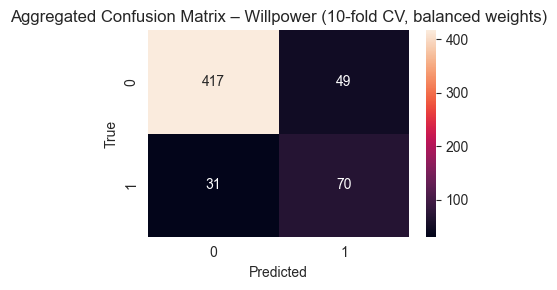


Top 20 positive predictor words (for class = 1):
push                            1.7830
try                             1.1711
belve                           1.1586
go                              1.1304
ill                             1.0019
matter                          0.9788
focused                         0.9556
keep                            0.9344
foucse                          0.9270
tre                             0.9125
want                            0.8972
mathia                          0.8532
continue                        0.8417
person                          0.8282
belive                          0.8158
work                            0.8067
keept                           0.7909
will                            0.7778
stuck                           0.7443
persevere                       0.7423

Top 20 negative predictor words (for class = 1):
grade                          -1.3557
math                           -1.2717
think                          -1.1364
fai

,Positive Feature,Positive Weight,Negative Feature,Negative Weight
0,push,1.782969,grade,-1.355715
1,try,1.171063,math,-1.271741
2,belve,1.158567,think,-1.136439
3,go,1.130414,fail,-0.824653
4,ill,1.001907,hate,-0.788980
5,matter,0.978824,calm,-0.782654
6,focused,0.955606,read,-0.781212
7,keep,0.934358,step,-0.662374
8,foucse,0.926986,nan,-0.659010
9,tre,0.912453,reward,-0.616875



Running MODEL for Performance Self-Talk

========== 10-fold CV Summary (class_weight=balanced) ==========
Mean Accuracy:  0.915 (+/- 0.036)
Mean Precision: 0.603 (+/- 0.246)
Mean Recall:    0.580 (+/- 0.189)
Mean F1-score:  0.555 (+/- 0.137)


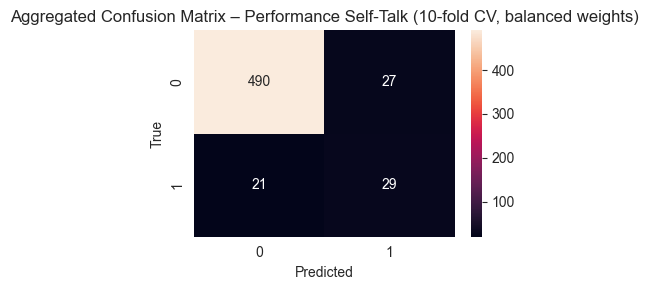


Top 20 positive predictor words (for class = 1):
grade                           3.7463
people                          1.1415
tellig                          1.1272
don                             1.0916
well                            1.0859
homework                        1.0789
improve                         1.0692
test                            1.0433
workspace                       1.0409
zero                            0.9773
progress                        0.9487
away                            0.9487
ill                             0.9289
feel                            0.9195
possible                        0.9131
acadamy                         0.9084
pass                            0.9071
to                              0.8406
hall                            0.8406
recess                          0.8406

Top 20 negative predictor words (for class = 1):
tell                           -1.0621
fail                           -0.8423
not                            -0.8078
nan

,Positive Feature,Positive Weight,Negative Feature,Negative Weight
0,grade,3.746299,tell,-1.062144
1,people,1.141479,fail,-0.842269
2,tellig,1.127227,not,-0.807767
3,don,1.091588,nan,-0.686785
4,well,1.085882,focus,-0.595239
5,homework,1.078900,help,-0.539378
6,improve,1.069172,right,-0.538707
7,test,1.043315,outside,-0.513464
8,workspace,1.040890,soon,-0.497367
9,zero,0.977295,m,-0.482945



Running MODEL for Effort

========== 10-fold CV Summary (class_weight=balanced) ==========
Mean Accuracy:  0.887 (+/- 0.024)
Mean Precision: 0.335 (+/- 0.091)
Mean Recall:    0.495 (+/- 0.205)
Mean F1-score:  0.388 (+/- 0.116)


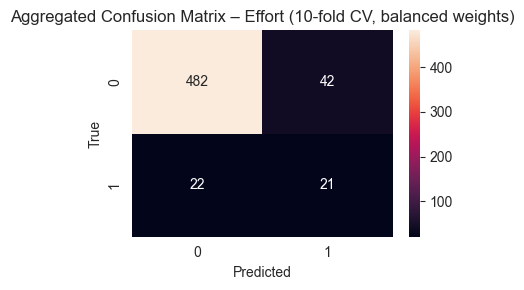


Top 20 positive predictor words (for class = 1):
everyday                        2.2647
reward                          1.7371
wrong                           1.7326
solution                        1.6551
motivated                       1.2988
use                             1.2879
look                            1.2103
figure                          1.1775
orkpsace                        1.0925
couple                          1.0925
equation                        1.0881
problem                         1.0558
caculate                        1.0556
hope                            1.0141
question                        1.0140
hint                            1.0107
class                           0.9646
content                         0.9420
hit                             0.8489
hecke                           0.8489

Top 20 negative predictor words (for class = 1):
grade                          -1.0822
agree                          -0.8498
nan                            -0.8259
wan

,Positive Feature,Positive Weight,Negative Feature,Negative Weight
0,everyday,2.264745,grade,-1.082180
1,reward,1.737101,agree,-0.849812
2,wrong,1.732614,nan,-0.825898
3,solution,1.655071,want,-0.799056
4,motivated,1.298850,m,-0.795942
5,use,1.287936,write,-0.787527
6,look,1.210266,finish,-0.764634
7,figure,1.177503,realize,-0.757688
8,couple,1.092531,teacher,-0.648530
9,orkpsace,1.092531,good,-0.647504


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ========= YOUR CV FUNCTION (streamlined, same as you wrote) =========

def run_logreg_cv_for_code_balanced(code_col, text_df_filtered, tfidf_df,
                                    n_splits=10,
                                    shuffle_seed=14312):
    """
    10-fold cross-validation for a single human code.

    - Uses the FULL original (imbalanced) dataset for both train and test
    - No resampling; handles imbalance via class_weight='balanced'
    - For EACH fold:
        * Train logistic regression on imbalanced training data
        * Evaluate on imbalanced test data
    - Prints mean accuracy/precision/recall/F1 across folds
    - Shows aggregated confusion matrix across folds
    - Returns averaged coefficients + top positive/negative predictor words
    """

    col = text_df_filtered[code_col]
    y_raw = pd.to_numeric(col, errors='coerce').fillna(0).astype(int)

    valid_idx = tfidf_df.index.intersection(y_raw.index)
    X = tfidf_df.loc[valid_idx]
    y = y_raw.loc[valid_idx]

    if y.nunique() < 2:
        return None

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=shuffle_seed)

    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []

    labels = sorted(y.unique())
    agg_confusion = np.zeros((len(labels), len(labels)), dtype=int)

    coef_list = []

    fold_id = 1
    for train_idx, test_idx in skf.split(X, y):

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        clf = LogisticRegression(
            max_iter=1000,
            class_weight='balanced'
        )
        clf.fit(X_train, y_train)

        coef_list.append(clf.coef_[0].copy())

        y_pred = clf.predict(X_test)

        acc = metrics.accuracy_score(y_test, y_pred)
        prec = metrics.precision_score(y_test, y_pred, zero_division=0)
        rec = metrics.recall_score(y_test, y_pred, zero_division=0)
        f1 = metrics.f1_score(y_test, y_pred, zero_division=0)

        fold_accuracies.append(acc)
        fold_precisions.append(prec)
        fold_recalls.append(rec)
        fold_f1s.append(f1)

        cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
        agg_confusion += cm

        fold_id += 1

    print("\n========== 10-fold CV Summary (class_weight=balanced) ==========")
    print(f"Mean Accuracy:  {np.mean(fold_accuracies):.3f} (+/- {np.std(fold_accuracies):.3f})")
    print(f"Mean Precision: {np.mean(fold_precisions):.3f} (+/- {np.std(fold_precisions):.3f})")
    print(f"Mean Recall:    {np.mean(fold_recalls):.3f} (+/- {np.std(fold_recalls):.3f})")
    print(f"Mean F1-score:  {np.mean(fold_f1s):.3f} (+/- {np.std(fold_f1s):.3f})")

    plt.figure(figsize=(4, 3))
    sns.heatmap(agg_confusion,
                annot=True,
                fmt='d',
                xticklabels=labels,
                yticklabels=labels)
    plt.title(f'Aggregated Confusion Matrix – {code_col} (10-fold CV, balanced weights)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # Average coefficients across folds
    coef_mean = np.mean(coef_list, axis=0)   # shape: (n_features,)
    feature_names = np.array(X.columns)

    # Pre-compute top 20 pos/neg (optional, but convenient)
    top_pos_idx = np.argsort(coef_mean)[-20:][::-1]
    top_pos_words = feature_names[top_pos_idx]
    top_pos_coefs = coef_mean[top_pos_idx]

    top_neg_idx = np.argsort(coef_mean)[:20]
    top_neg_words = feature_names[top_neg_idx]
    top_neg_coefs = coef_mean[top_neg_idx]

    print("\nTop 20 positive predictor words (for class = 1):")
    for w, c in zip(top_pos_words, top_pos_coefs):
        print(f"{w:30s} {c: .4f}")

    print("\nTop 20 negative predictor words (for class = 1):")
    for w, c in zip(top_neg_words, top_neg_coefs):
        print(f"{w:30s} {c: .4f}")

    results = {
        "accuracy": fold_accuracies,
        "precision": fold_precisions,
        "recall": fold_recalls,
        "f1": fold_f1s,
        "labels": labels,
        "confusion_matrix": agg_confusion,
        "coef_mean": coef_mean,
        "feature_names": feature_names,
        "top_pos_words": top_pos_words,
        "top_pos_coefs": top_pos_coefs,
        "top_neg_words": top_neg_words,
        "top_neg_coefs": top_neg_coefs
    }
    return results


# ========= SIDE-BY-SIDE TABLE + POS/NEG EXTRACTOR COMPATIBLE WITH THIS MODEL =========

def get_positive_negative_features_from_results(results, top_k=20):
    """
    Take the `results` dict returned by run_logreg_cv_for_code_balanced
    and return pos/neg coefficient Series indexed by feature names.
    """
    coef_mean = results["coef_mean"]
    feature_names = results["feature_names"]

    coef_series = pd.Series(coef_mean, index=feature_names)

    pos = coef_series[coef_series > 0].sort_values(ascending=False)
    neg = coef_series[coef_series < 0].sort_values()

    if top_k is not None:
        pos = pos.head(top_k)
        neg = neg.head(top_k)

    return pos, neg


def make_side_by_side_table(pos, neg, code_name):
    """
    pos, neg: pd.Series (coefficients), indexed by feature names.
    """
    pos = pd.Series(pos)
    neg = pd.Series(neg)

    df_pos = pos.reset_index()
    df_pos.columns = ['Positive Feature', 'Positive Weight']

    df_neg = neg.reset_index()
    df_neg.columns = ['Negative Feature', 'Negative Weight']

    max_len = max(len(df_pos), len(df_neg))
    df_pos = df_pos.reindex(range(max_len))
    df_neg = df_neg.reindex(range(max_len))

    table = pd.concat([df_pos, df_neg], axis=1)

    print(f"\n=== {code_name}: Positive vs. Negative Features ===")
    display(table)

    return table


# ========= LOOP OVER CODES USING YOUR MODEL OUTPUT =========

codes = ['Willpower', 'Performance Self-Talk', 'Effort']

reduced_results = {}
side_by_side_tables = {}

for code in codes:
    print("\n==============================")
    print(f"Running MODEL for {code}")
    print("==============================")

    # Run your CV + coefficient aggregation
    results = run_logreg_cv_for_code_balanced(
        code_col=code,
        text_df_filtered=text_df_filtered,
        tfidf_df=tfidf_df
    )

    if results is None:
        print(f"Skipping {code}: not enough variation.")
        continue

    # Save full results
    reduced_results[code] = results

    # Get pos/neg Series from the *same* results dict
    pos, neg = get_positive_negative_features_from_results(results, top_k=20)

    # Store word lists for spaCy etc.
    reduced_results[code]['pos_features'] = list(pos.index)
    reduced_results[code]['neg_features'] = list(neg.index)

    # Make side-by-side table
    table = make_side_by_side_table(pos, neg, code)
    side_by_side_tables[code] = table


In [45]:
from scipy.stats import ttest_ind

def get_positive_negative_features_from_results(results, top_k=20):
    """
    Take the `results` dict returned by run_logreg_cv_for_code_balanced
    and return pos/neg coefficient Series indexed by feature names.
    """
    coef_mean = results["coef_mean"]
    feature_names = results["feature_names"]

    coef_series = pd.Series(coef_mean, index=feature_names)

    pos = coef_series[coef_series > 0].sort_values(ascending=False)
    neg = coef_series[coef_series < 0].sort_values()

    if top_k is not None:
        pos = pos.head(top_k)
        neg = neg.head(top_k)

    return pos, neg


In [46]:
def spacy_similarity_for_code(
    code_name,
    reduced_results,
    text_df,
    tfidf_df,
    text_col="input",
    top_k=20,
    nlp_model=None
):
    """
    For a given code (e.g., 'Willpower'):
      - use the stored ML results (coef_mean + feature_names) to get positive features
      - compute spaCy similarity for each example used in the ML model
      - run a t-test comparing similarity scores for labels 0 vs 1
    """

    if nlp_model is None:
        # assumes you've already done something like: nlp = spacy.load("en_core_web_md")
        # and you pass nlp_model=nlp when calling
        raise ValueError("Please pass a spaCy model via nlp_model=...")

    # 1) get results dict for this code
    entry = reduced_results[code_name]

    # 2) get positive / negative features from ML results
    pos, neg = get_positive_negative_features_from_results(entry, top_k=top_k)
    pos_words = list(pos.index)

    if len(pos_words) == 0:
        print(f"No positive features found for {code_name}.")
        return None, None, None, (None, None), None

    # 3) build reference spaCy doc from positive words
    ref_text = " ".join(pos_words)
    ref_doc  = nlp_model(ref_text)

    # 4) reconstruct y (labels) the SAME way the ML model did
    #    - from text_df[code_name]
    col = text_df[code_name]
    y_raw = pd.to_numeric(col, errors='coerce').fillna(0).astype(int)

    # align text rows with tfidf rows
    valid_idx = tfidf_df.index.intersection(y_raw.index)

    texts = text_df.loc[valid_idx, text_col].fillna("")
    labels = y_raw.loc[valid_idx]      # 0/1 Series, aligned with texts

    # 5) compute similarity scores for each text
    docs = list(nlp_model.pipe(texts))
    sim_scores = [doc.similarity(ref_doc) for doc in docs]

    sim_scores = pd.Series(
        sim_scores,
        index=valid_idx,
        name=f"{code_name}_sim"
    )

    # 6) split by label and run t-test
    sims_0 = sim_scores[labels == 0]
    sims_1 = sim_scores[labels == 1]

    t, p = ttest_ind(sims_1, sims_0, equal_var=False)

    print(f"\n=== {code_name}: spaCy similarity t-test ===")
    print(f"Mean similarity (label 0): {sims_0.mean():.4f}  (n={len(sims_0)})")
    print(f"Mean similarity (label 1): {sims_1.mean():.4f}  (n={len(sims_1)})")
    print(f"t = {t:.4f}, p = {p:.4f}")

    # return labels as well so plotting code doesn't need to recompute
    return sim_scores, sims_0, sims_1, (t, p), labels


In [47]:
similarity_results = {}

for code in codes:
    sims, sims_0, sims_1, stats, labels = spacy_similarity_for_code(
        code_name=code,
        reduced_results=reduced_results,
        text_df=text_df_filtered,
        tfidf_df=tfidf_df,
        text_col="input",   # change if your text column name is different
        top_k=20,
        nlp_model=nlp       # your loaded spaCy model
    )

    similarity_results[code] = {
        'scores': sims,
        'scores_0': sims_0,
        'scores_1': sims_1,
        't_test': stats,
        'labels': labels
    }


/var/folders/13/9q4w_lnj0w5c08cw7_g1z1gr0000gn/T/ipykernel_8968/2407532170.py:50: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim_scores = [doc.similarity(ref_doc) for doc in docs]



=== Willpower: spaCy similarity t-test ===
Mean similarity (label 0): 0.6129  (n=466)
Mean similarity (label 1): 0.8332  (n=101)
t = 13.7537, p = 0.0000


/var/folders/13/9q4w_lnj0w5c08cw7_g1z1gr0000gn/T/ipykernel_8968/2407532170.py:50: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim_scores = [doc.similarity(ref_doc) for doc in docs]



=== Performance Self-Talk: spaCy similarity t-test ===
Mean similarity (label 0): 0.6050  (n=517)
Mean similarity (label 1): 0.7958  (n=50)
t = 8.5841, p = 0.0000

=== Effort: spaCy similarity t-test ===
Mean similarity (label 0): 0.6039  (n=524)
Mean similarity (label 1): 0.8469  (n=43)
t = 15.9558, p = 0.0000


/var/folders/13/9q4w_lnj0w5c08cw7_g1z1gr0000gn/T/ipykernel_8968/2407532170.py:50: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim_scores = [doc.similarity(ref_doc) for doc in docs]


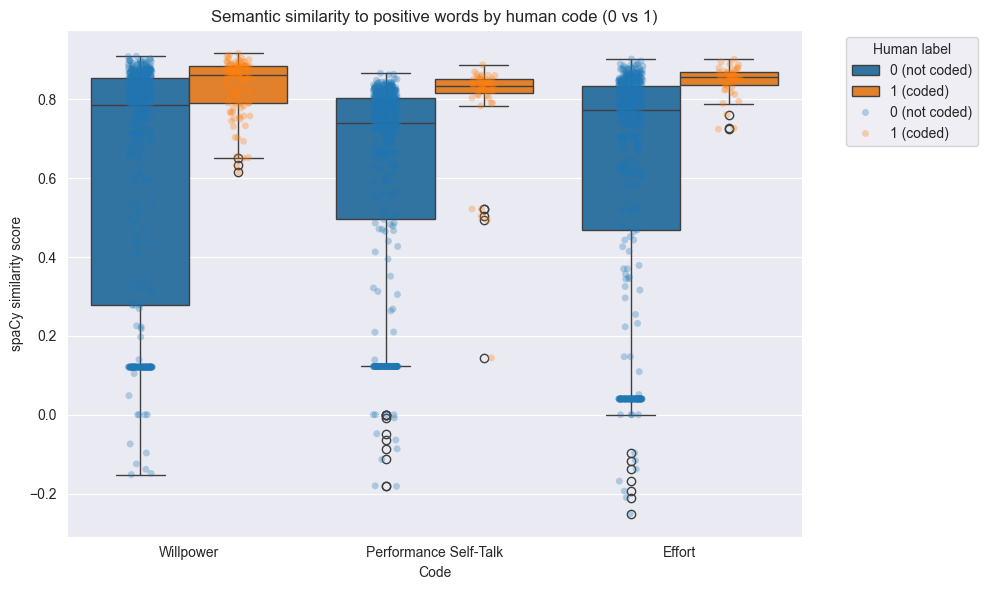

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rows = []

for code in codes:   # ['Effort', 'Performance Self-Talk', 'Willpower']
    sims   = similarity_results[code]['scores']   # Series of similarity scores
    labels = similarity_results[code]['labels']   # Series of 0/1 labels

    # align indices just in case
    common_idx = sims.index.intersection(labels.index)
    sims_use   = sims.loc[common_idx]
    labels_use = labels.loc[common_idx]

    for idx in common_idx:
        rows.append({
            'code': code,
            'label': labels_use.loc[idx],
            'similarity': sims_use.loc[idx]
        })

plot_df = pd.DataFrame(rows)
plot_df['label'] = plot_df['label'].map({0: '0 (not coded)', 1: '1 (coded)'})

plt.figure(figsize=(10, 6))
sns.boxplot(data=plot_df, x='code', y='similarity', hue='label')

sns.stripplot(
    data=plot_df, x='code', y='similarity', hue='label',
    dodge=True, alpha=0.3, linewidth=0
)

plt.title("Semantic similarity to positive words by human code (0 vs 1)")
plt.ylabel("spaCy similarity score")
plt.xlabel("Code")
plt.legend(title="Human label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
